# **Amazon Earphones Reviews**

This project consists of two main parts. In the first part
we will create NLP predictor. The second part is dedicated to create character-level text generator.

We will use Amazon Earphones Reviews dataset from Kaggle - https://www.kaggle.com/shitalkat/amazonearphonesreviews#AllProductReviews.csv.

This dataset consists of a 14337 Amazon reviews, star ratings, for 10 latest (as of mid-2019) bluetooth earphone devices.

## Table of Contents

>[Amazon Earphones Reviews](#scrollTo=9LCH-OVcCszZ)

>>[Table of Contents](#scrollTo=Ry-0kDe53cvx)

>>[Imports & Data Download](#scrollTo=lVeDBkDrfQY9)

>>[Data Exploration](#scrollTo=Gid45OwSzO7M)

>>[NLP Predictor](#scrollTo=voXbsKZtp79W)

>>>[Data Preprocessing](#scrollTo=m--OcMw_dFk6)

>>>[NLP Predictor - Model 1 - LSTM 64](#scrollTo=ugKPRGN7djcA)

>>>[NLP Predictor - Model 2 - LSTM 256](#scrollTo=vJQTsleN8-gn)

>>>[NLP Predictor - Model 3 - Emb 128, LSTM 256](#scrollTo=BmbJJIxPh5do)

>>>[NLP Predictor - Model 4](#scrollTo=JCerF5t4_EYR)

>>>[NLP Predictor - Model 5](#scrollTo=wmb5l2fBBhQZ)

>>>[NLP Predictor - Model](#scrollTo=W18KImtZGi53)

>>>[NLP Predictor - Con1D Model 1](#scrollTo=eom6lh0s_nXT)

>>>[Emb 128, conv_size128](#scrollTo=hXVU-aUWG4fr)

>>>[Emb 128, conv_size128](#scrollTo=Q1QKgwncHINc)

>>>[Emb 256, conv_size256](#scrollTo=MU1J6M-wHUX4)

>>[Wavenet](#scrollTo=VyppVOoGCSli)

>>[Text Generator](#scrollTo=DPf3olZFp0NF)

>>[Bidirectional](#scrollTo=1c1IQnfVR_SK)

>>[BD Conv](#scrollTo=0YzadaC2SWXW)

>[Conv1D](#scrollTo=WPwxTslIS45m)

>>[BD Conv](#scrollTo=VrxArsWAv2zl)

>>[Bidirectional](#scrollTo=dDoN4UCB0X_9)



## Imports & Data Download

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [0]:
SETUP = True

In [0]:
if SETUP:
    !pip install -q tensorflow-gpu==2.0.0
    !pip install -q -U toai

In [0]:
print(__import__("toai").__version__)
print(__import__("tensorflow").__version__)

0.2.2
2.0.0


In [0]:
from toai.imports import *
from toai.data import DataBundle, DataParams, DataContainer
from toai.metrics import sparse_top_2_categorical_accuracy
import tensorflow as tf
from tensorflow import keras

In [0]:
%matplotlib inline
plt.style.use('seaborn')

In [0]:
tf.get_logger().setLevel("ERROR")

In [0]:
DATA_DIR = Path('./gdrive/My Drive/Projects/12_earphones_reviews/data/reviews')
TEMP_DIR = Path('./gdrive/My Drive/Projects/12_earphones_reviews/temp/reviews')

In [0]:
df = pd.read_csv(DATA_DIR/'AllProductReviews.csv', low_memory=False)

## Data Exploration

In [0]:
df.shape

(14337, 4)

In [0]:
df.head(3).T

,0,1,2
ReviewTitle,Honest review of an edm music lover\n,Unreliable earphones with high cost\n,Really good and durable.\n
ReviewBody,No doubt it has a great bass and to a great ex...,"This earphones are unreliable, i bought it be...","i bought itfor 999,I purchased it second time,..."
ReviewStar,3,1,4
Product,boAt Rockerz 255,boAt Rockerz 255,boAt Rockerz 255


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14337 entries, 0 to 14336
Data columns (total 4 columns):
ReviewTitle    14337 non-null object
ReviewBody     14337 non-null object
ReviewStar     14337 non-null int64
Product        14337 non-null object
dtypes: int64(1), object(3)
memory usage: 448.2+ KB


In [0]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ReviewTitle,14337,9342,Good\n,428,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ReviewBody,14337,13012,Good\n,242,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ReviewStar,14337,NaN,NaN,NaN,3.67587,1.50341,1,3,4,5,5
Product,14337,10,Sennheiser CX 6.0BT,5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
df["ReviewBody"].value_counts().head(350)

Good\n                                                                                                                                                     242
Good product\n                                                                                                                                              77
Nice\n                                                                                                                                                      71
Awesome\n                                                                                                                                                   45
Nice product\n                                                                                                                                              38
                                                                                                                                                          ... 
Overall balanced sound\n                      

Text(0.5, 1.0, 'ReviewStar Distribution')

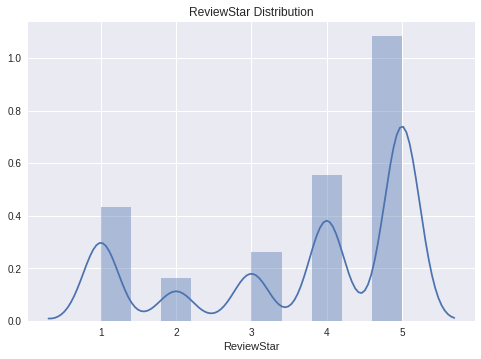

In [0]:
sns.distplot(df['ReviewStar'], bins=10).set_title('ReviewStar Distribution')

Text(0.5, 1.0, 'ReviewStar Distribution')

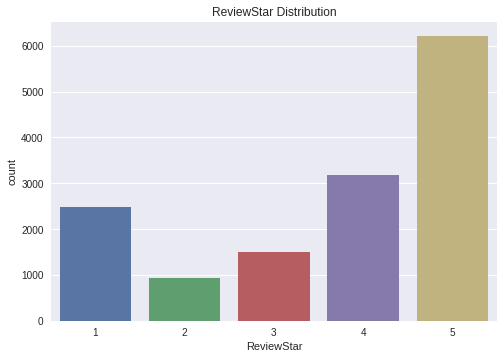

In [0]:
plt.style.use('seaborn')
sns.countplot(df['ReviewStar']).set_title('ReviewStar Distribution')

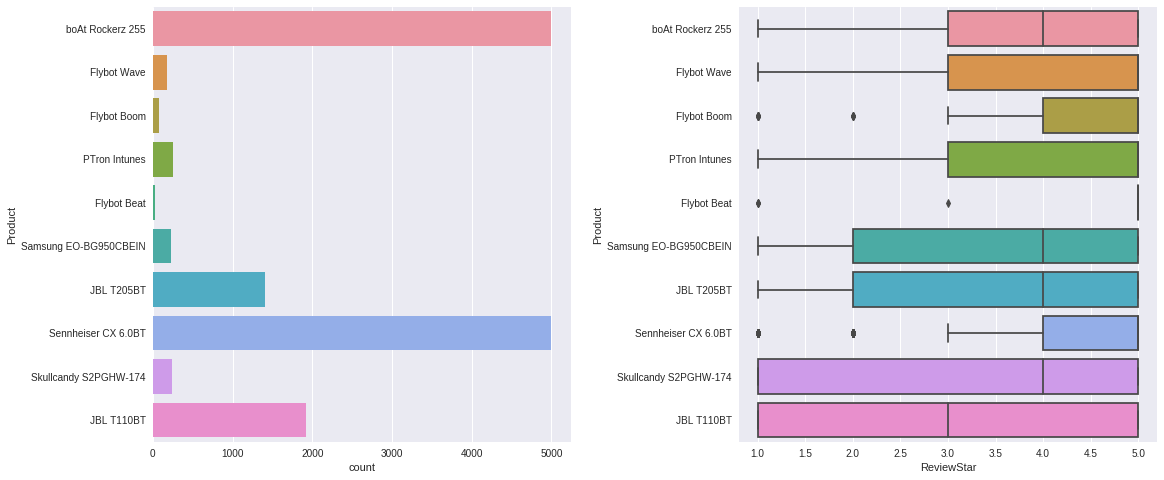

In [0]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.countplot(y='Product', data=df, ax=ax[0])
sns.boxplot(x='ReviewStar',y='Product',data=df, ax=ax[1])
plt.subplots_adjust(wspace=0.4)

In [0]:
# Number of words
df['review_body_word_count'] = df['ReviewBody'].str.split().str.len()

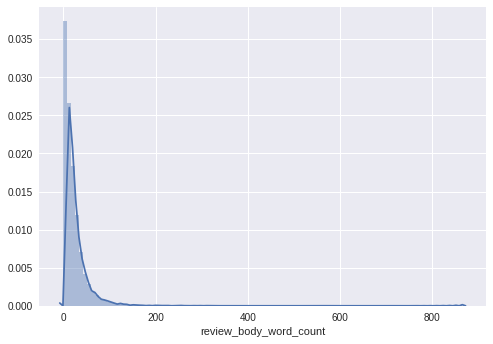

In [0]:
sns.distplot(df.review_body_word_count, bins=100)

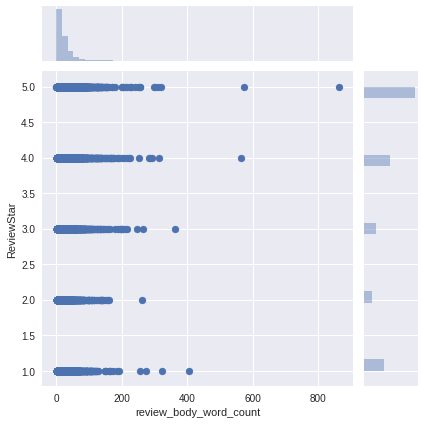

In [0]:
sns.jointplot(x="review_body_word_count", y="ReviewStar", data=df);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f614ffce278>,
      dtype=object)

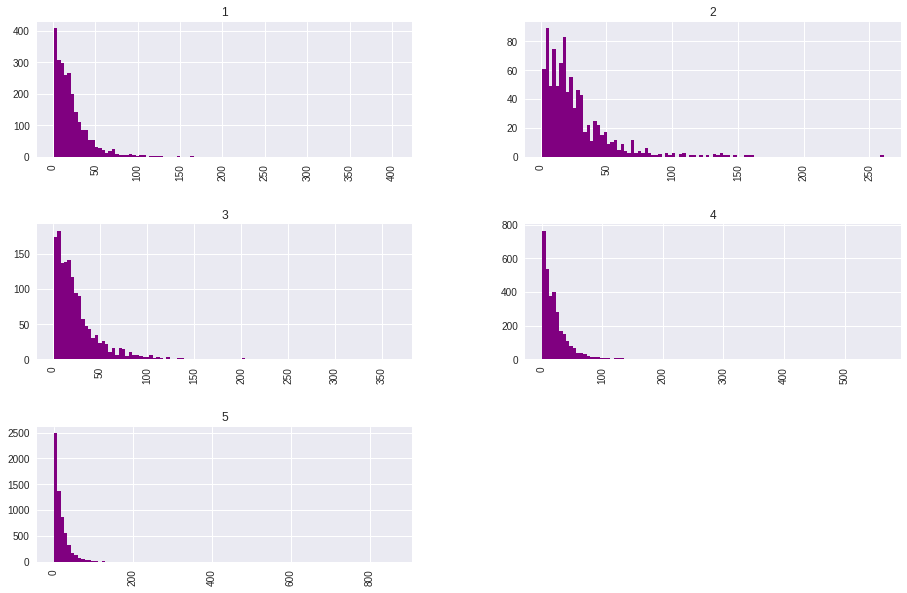

In [0]:
df.hist(column='review_body_word_count', by='ReviewStar', bins=100, figsize=(15, 10), color='purple')

In [0]:
# Dropping reviews shorter than 20 characters
new_df = df.loc[df['ReviewBody'].str.len() > 20, :].reset_index(
        drop=True
    )

In [0]:
new_df['ReviewBody'].str.len().describe()

count    12172.000000
mean       147.074515
std        159.510030
min         21.000000
25%         58.000000
50%        105.000000
75%        179.000000
max       5046.000000
Name: ReviewBody, dtype: float64

In [0]:
new_df['ReviewStar'].value_counts()

5    4943
4    2720
1    2275
3    1359
2     875
Name: ReviewStar, dtype: int64

In [0]:
new_df.to_csv(TEMP_DIR/'AllProductReviews_mod.csv', index=False)

## NLP Predictor 

We will create NLP Predictor to predict ReviewStar based on ReviewBody.

### NLP Predictor - Data Preprocessing

In [0]:
BATCH_SIZE = 32

In [0]:
df = pd.read_csv(TEMP_DIR/'AllProductReviews_mod.csv')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12172 entries, 0 to 12171
Data columns (total 4 columns):
ReviewTitle    12172 non-null object
ReviewBody     12172 non-null object
ReviewStar     12172 non-null int64
Product        12172 non-null object
dtypes: int64(1), object(3)
memory usage: 380.5+ KB


In [0]:
df["ReviewStar"].value_counts()

5    4943
4    2720
1    2275
3    1359
2     875
Name: ReviewStar, dtype: int64

In [0]:
def make_category_map(labels):
    return {x: i for i, x in enumerate(set(labels))}

In [0]:
category_map = make_category_map(df["ReviewStar"].values)

In [0]:
category_map

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4}

In [0]:
n_categories = len(category_map)

In [0]:
df["ReviewStar"] = df["ReviewStar"].map(category_map)

In [0]:
data_container = DataContainer(
    *DataBundle.split(
        data_bundle=DataBundle.from_dataframe(
            dataframe=df, x_col="ReviewBody", y_col="ReviewStar"
        ),
        fracs=[0.7, 0.15, 0.15],
    )
)

In [0]:
class_weights = dict(
    enumerate(
        sk.utils.class_weight.compute_class_weight(
            "balanced", np.unique(data_container.train.y), data_container.train.y
        )
    )
)

In [0]:
class_weights

{0: 1.065125,
 1: 2.8498327759197326,
 2: 1.7826359832635983,
 3: 0.8862194487779511,
 4: 0.4948315911730546}

In [0]:
len(data_container.train), len(data_container.validation), len(data_container.test)

(8521, 1826, 1825)

In [0]:
def make_dataset(data_bundle):
    return tf.data.Dataset.from_tensor_slices((data_bundle.x, data_bundle.y))

In [0]:
data_container.train.dataset = make_dataset(data_container.train)
data_container.validation.dataset = make_dataset(data_container.validation)
data_container.test.dataset = make_dataset(data_container.test)

In [0]:
data_container.train.x[4]

'Sound quality is best though little bit disappointed with battery life, best for outdoor workout.\n'

In [0]:
data_container.train.y[4]

3

In [0]:
data_container.train.x[2]

"The product is unserviceable just within three months of purchase. Don't recommend immediate buy unless some more development takes place in product\n"

In [0]:
data_container.train.y[2]

2

In [0]:
def preprocess(x, y, max_length=200):
    x = tf.strings.regex_replace(x, rb"<br\s*/?>", b" ")
    x = tf.strings.regex_replace(x, b"[^a-zA-Z']", b" ")
    x = tf.strings.split(x)
    x = x[:, :max_length]
    return x.to_tensor(default_value=b"<pad>"), y

In [0]:
for x, y in data_container.train.dataset.batch(BATCH_SIZE).map(preprocess).take(1):
    print(x.shape)
    print(y.shape)
    print(x[4])
    print(y[4])

(32, 63)
(32,)
tf.Tensor(
[b'Sound' b'quality' b'is' b'best' b'though' b'little' b'bit'
 b'disappointed' b'with' b'battery' b'life' b'best' b'for' b'outdoor'
 b'workout' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>'], shape=(63,), dtype=string)
tf.Tensor(3, shape=(), dtype=int64)


In [0]:
def make_vocabulary(dataset):
    vocabulary = Counter()
    for x, _ in dataset.batch(BATCH_SIZE).map(preprocess):
        for review in x:
            vocabulary.update(review.numpy().tolist())
    return vocabulary

In [0]:
vocabulary = make_vocabulary(data_container.train.dataset)

In [0]:
# Most common words
vocabulary.most_common()[:10]

[(b'<pad>', 764692),
 (b'is', 8246),
 (b'the', 6332),
 (b'and', 4749),
 (b'it', 4030),
 (b'quality', 3920),
 (b'good', 3848),
 (b'for', 3771),
 (b'to', 3503),
 (b'I', 3464)]

In [0]:
# Least common words
vocabulary.most_common()[-10:]

[(b'Supperbb', 1),
 (b'listining', 1),
 (b'heathy', 1),
 (b'finished', 1),
 (b'oprion', 1),
 (b'SUCCKSS', 1),
 (b'tangental', 1),
 (b'onThis', 1),
 (b'Milli', 1),
 (b'Helpful', 1)]

In [0]:
len(vocabulary)

10240

In [0]:
VOCABULARY_SIZE = 10000

In [0]:
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:VOCABULARY_SIZE]
]

In [0]:
len(truncated_vocabulary)

10000

In [0]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}

In [0]:
for word in b"Fits great in ears".split():
    print(word_to_id.get(word) or VOCABULARY_SIZE)

976
51
16
118


In [0]:
for word in b"Fits great in Mouth".split():
    print(word_to_id.get(word) or VOCABULARY_SIZE)

976
51
16
10000


In [0]:
words = tf.constant(truncated_vocabulary)

In [0]:
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)

In [0]:
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)

In [0]:
n_oov_buckets = 200

In [0]:
table = tf.lookup.StaticVocabularyTable(vocab_init, n_oov_buckets)

In [0]:
table.lookup(tf.constant([b"This earphone is made of banana".split()]))

<tf.Tensor: id=416827, shape=(1, 6), dtype=int64, numpy=array([[   88,    43,     1,   447,    14, 10156]])>

In [0]:
def encode_words(x, y):
    return table.lookup(x), y

In [0]:
train_dataset = (
    data_container.train.dataset.repeat()
    .batch(BATCH_SIZE)
    .map(preprocess)
    .map(encode_words)
    .prefetch(1)
)

In [0]:
validation_dataset = (
    data_container.validation.dataset.batch(BATCH_SIZE)
    .map(preprocess)
    .map(encode_words)
)

In [0]:
test_dataset = (
    data_container.test.dataset.batch(BATCH_SIZE)
    .map(preprocess)
    .map(encode_words)
)

In [0]:
for x, y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x[0])
    print(y[0])

(32, 63)
(32,)
tf.Tensor(
[ 24   5   1 244 234  44 182 887 633 164 189 135 236 529  22 202   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0], shape=(63,), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)


In [0]:
for x, y in validation_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x[0])
    print(y[0])

(32, 63)
(32,)
tf.Tensor(
[    9    26   108    63    12    11   296    71     3    34   895    13
    94    15   557   175    17    25   158    32    25    96    14    33
   127    36    34  2021     2   135     3     2   146   474  1338    35
   258 10081     9   332   214    81     7     4     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0], shape=(63,), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)


In [0]:
train_dataset_steps = len(data_container.train) // BATCH_SIZE

In [0]:
validation_dataset_steps = len(data_container.validation) // BATCH_SIZE

In [0]:
test_dataset_steps = len(data_container.test) // BATCH_SIZE

### NLP Predictor - Model 1 - Emb64 2xBidLSTM64 Dropout 0.2 0.5

We will start with Bidirectional LSTM model. Initial hyperparameters:

    embedding_size=64,
    lstm_size=64,
    lstm_dropout=0.2,
    dropout=0.5,
    keras.optimizers.Adam(lr=1e-4)
    epochs=15

In [0]:
def make_sequential_lstm_model(
    n_categories, embedding_size, lstm_size, lstm_dropout, dropout
):
    return keras.models.Sequential(
        [
            keras.layers.Embedding(
                VOCABULARY_SIZE + n_oov_buckets,
                embedding_size,
                mask_zero=True,
                input_shape=[None],
            ),
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    lstm_size, dropout=lstm_dropout, return_sequences=True
                )
            ),
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    lstm_size, dropout=lstm_dropout, return_sequences=True
                )
            ),
            keras.layers.GlobalMaxPool1D(),
            keras.layers.Dropout(dropout),
            keras.layers.Dense(n_categories, activation=keras.activations.softmax),
        ]
    )

In [0]:
model = make_sequential_lstm_model(
    n_categories=n_categories,
    embedding_size=64,
    lstm_size=64,
    lstm_dropout=0.2,
    dropout=0.5,
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=15,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_cl_2lstm.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 266 steps, validate for 57 steps
Epoch 1/15
266/266 [==============================] - 45s 170ms/step - loss: 1.5301 - sparse_categorical_accuracy: 0.3937 - sparse_top_2_categorical_accuracy: 0.6118 - val_loss: 1.4429 - val_sparse_categorical_accuracy: 0.4145 - val_sparse_top_2_categorical_accuracy: 0.6453
Epoch 2/15
266/266 [==============================] - 19s 72ms/step - loss: 1.3507 - sparse_categorical_accuracy: 0.4576 - sparse_top_2_categorical_accuracy: 0.6982 - val_loss: 1.2035 - val_sparse_categorical_accuracy: 0.5247 - val_sparse_top_2_categorical_accuracy: 0.7686
Epoch 3/15
266/266 [==============================] - 19s 70ms/step - loss: 1.1436 - sparse_categorical_accuracy: 0.5469 - sparse_top_2_categorical_accuracy: 0.7877 - val_loss: 1.1229 - val_sparse_categorical_accuracy: 0.5422 - val_sparse_top_2_categorical_accuracy: 0.7950
Epoch 4/15
266/266 [==============================] - 19s 72ms/step - loss: 1.0630 - sparse_categorical_accuracy: 0.5732 - sparse_top_

In [0]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 64)          652800    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, None, 128)         66048     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, None, 128)         98816     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 645       
Total params: 818,309
Trainable params: 818,309
Non-trainable params: 0
________________________________________________

In [0]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

57/57 [==============================] - 1s 23ms/step - loss: 1.0859 - sparse_categorical_accuracy: 0.5504 - sparse_top_2_categorical_accuracy: 0.8130


[1.08594733894917, 0.5504386, 0.81304824]

In [0]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.52      0.85      0.64       338
           1       0.00      0.00      0.00       122
           2       0.31      0.10      0.15       198
           3       0.32      0.26      0.29       411
           4       0.67      0.78      0.72       757

    accuracy                           0.55      1826
   macro avg       0.36      0.40      0.36      1826
weighted avg       0.48      0.55      0.50      1826



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
def show_history(model, contains, skip=0):
        history_df = pd.DataFrame(model.history.history)
        history_df[list(history_df.filter(regex=contains))].iloc[skip:].plot()

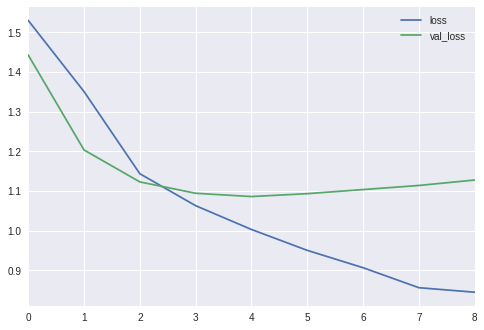

In [0]:
show_history(model, contains='loss', skip=0)

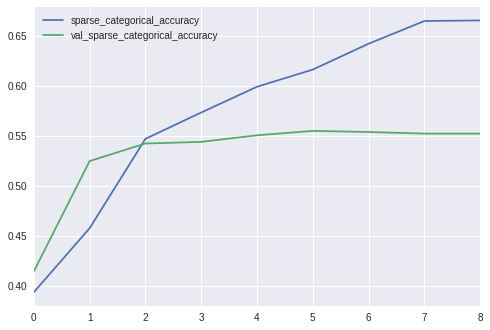

In [0]:
show_history(model, contains='sparse_categorical_accuracy', skip=0)

### NLP Predictor - Model 2 - Emb64 2xBidLSTM256 Dropout 0.2 0.5


We increase LSTM size from 64 to 256.

In [0]:
model = make_sequential_lstm_model(
    n_categories=n_categories,
    embedding_size=64,
    lstm_size=256,
    lstm_dropout=0.2,
    dropout=0.5,
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=15,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_cl_2lstm256.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 266 steps, validate for 57 steps
Epoch 1/15
266/266 [==============================] - 47s 177ms/step - loss: 1.4410 - sparse_categorical_accuracy: 0.4241 - sparse_top_2_categorical_accuracy: 0.6546 - val_loss: 1.2285 - val_sparse_categorical_accuracy: 0.5110 - val_sparse_top_2_categorical_accuracy: 0.7462
Epoch 2/15
266/266 [==============================] - 20s 75ms/step - loss: 1.1590 - sparse_categorical_accuracy: 0.5368 - sparse_top_2_categorical_accuracy: 0.7751 - val_loss: 1.1242 - val_sparse_categorical_accuracy: 0.5428 - val_sparse_top_2_categorical_accuracy: 0.7829
Epoch 3/15
266/266 [==============================] - 20s 76ms/step - loss: 1.0459 - sparse_categorical_accuracy: 0.5746 - sparse_top_2_categorical_accuracy: 0.8179 - val_loss: 1.0793 - val_sparse_categorical_accuracy: 0.5488 - val_sparse_top_2_categorical_accuracy: 0.8054
Epoch 4/15
266/266 [==============================] - 19s 73ms/step - loss: 0.9704 - sparse_categorical_accuracy: 0.6064 - sparse_top_

In [0]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 64)          652800    
_________________________________________________________________
bidirectional_14 (Bidirectio (None, None, 512)         657408    
_________________________________________________________________
bidirectional_15 (Bidirectio (None, None, 512)         1574912   
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 512)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 2565      
Total params: 2,887,685
Trainable params: 2,887,685
Non-trainable params: 0
____________________________________________

In [0]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

57/57 [==============================] - 1s 23ms/step - loss: 1.0793 - sparse_categorical_accuracy: 0.5488 - sparse_top_2_categorical_accuracy: 0.8054


[1.0792893620959498, 0.54879385, 0.80537283]

In [0]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.53      0.81      0.64       338
           1       0.00      0.00      0.00       122
           2       0.42      0.04      0.07       198
           3       0.27      0.17      0.21       411
           4       0.63      0.86      0.73       757

    accuracy                           0.55      1826
   macro avg       0.37      0.38      0.33      1826
weighted avg       0.47      0.55      0.48      1826



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


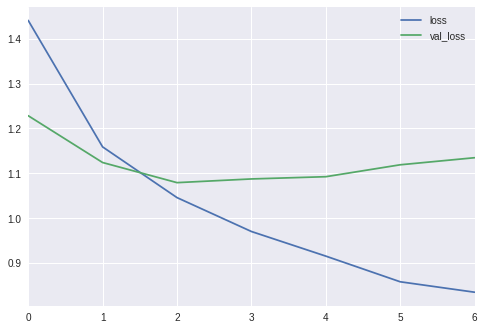

In [0]:
show_history(model, contains='loss', skip=0)

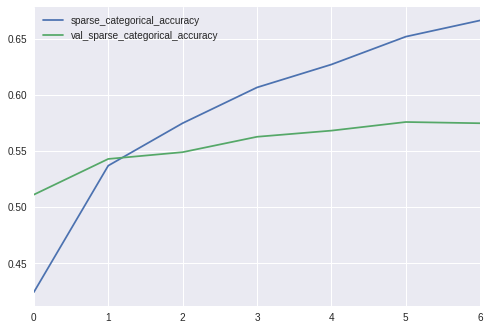

In [0]:
show_history(model, contains='sparse_categorical_accuracy', skip=0)

### NLP Predictor - Model 3 - Emb128 2xBidLSTM256 Dropout 0.2 0.5

Changing embedding size to 128, LSTM size to 256.

In [0]:
model = make_sequential_lstm_model(
    n_categories=n_categories,
    embedding_size=128,
    lstm_size=256,
    lstm_dropout=0.2,
    dropout=0.5,
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=15,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_cl_2lstm256_emb128.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 266 steps, validate for 57 steps
Epoch 1/15
266/266 [==============================] - 50s 186ms/step - loss: 1.3999 - sparse_categorical_accuracy: 0.4430 - sparse_top_2_categorical_accuracy: 0.6787 - val_loss: 1.1791 - val_sparse_categorical_accuracy: 0.5241 - val_sparse_top_2_categorical_accuracy: 0.7621
Epoch 2/15
266/266 [==============================] - 23s 88ms/step - loss: 1.1170 - sparse_categorical_accuracy: 0.5515 - sparse_top_2_categorical_accuracy: 0.7945 - val_loss: 1.0903 - val_sparse_categorical_accuracy: 0.5521 - val_sparse_top_2_categorical_accuracy: 0.7993
Epoch 3/15
266/266 [==============================] - 23s 87ms/step - loss: 1.0070 - sparse_categorical_accuracy: 0.5913 - sparse_top_2_categorical_accuracy: 0.8305 - val_loss: 1.0764 - val_sparse_categorical_accuracy: 0.5680 - val_sparse_top_2_categorical_accuracy: 0.8070
Epoch 4/15
266/266 [==============================] - 22s 82ms/step - loss: 0.9264 - sparse_categorical_accuracy: 0.6284 - sparse_top_

In [0]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 128)         1305600   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, None, 512)         788480    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, None, 512)         1574912   
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 512)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 2565      
Total params: 3,671,557
Trainable params: 3,671,557
Non-trainable params: 0
____________________________________________

In [0]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

57/57 [==============================] - 1s 24ms/step - loss: 1.0764 - sparse_categorical_accuracy: 0.5680 - sparse_top_2_categorical_accuracy: 0.8070


[1.0763829224988033, 0.56798244, 0.80701756]

In [0]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.57      0.78      0.66       338
           1       0.00      0.00      0.00       122
           2       0.30      0.09      0.13       198
           3       0.33      0.23      0.27       411
           4       0.65      0.88      0.75       757

    accuracy                           0.57      1826
   macro avg       0.37      0.39      0.36      1826
weighted avg       0.48      0.57      0.51      1826



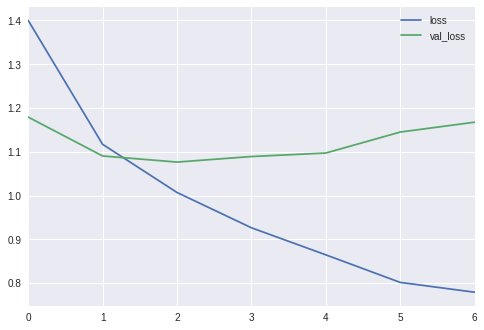

In [0]:
show_history(model, contains='loss', skip=0)

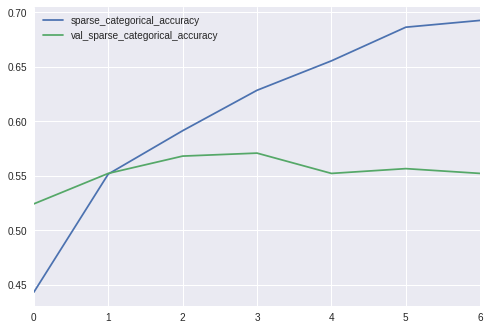

In [0]:
show_history(model, contains='sparse_categorical_accuracy', skip=0)

### NLP Predictor - Model 4 - Emb64 2xBidLSTM 64 Dropout 0.2 0.2

Changing dropout from 0.5 to 0.2. Embedding and LSTM - 64.

In [0]:
model = make_sequential_lstm_model(
    n_categories=n_categories,
    embedding_size=64,
    lstm_size=64,
    lstm_dropout=0.2,
    dropout=0.2,
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=15,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_cl_2lstm_dropout_02.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 266 steps, validate for 57 steps
Epoch 1/15
266/266 [==============================] - 48s 182ms/step - loss: 1.5168 - sparse_categorical_accuracy: 0.3956 - sparse_top_2_categorical_accuracy: 0.6236 - val_loss: 1.4229 - val_sparse_categorical_accuracy: 0.4145 - val_sparse_top_2_categorical_accuracy: 0.6497
Epoch 2/15
266/266 [==============================] - 19s 70ms/step - loss: 1.2879 - sparse_categorical_accuracy: 0.4848 - sparse_top_2_categorical_accuracy: 0.7289 - val_loss: 1.1640 - val_sparse_categorical_accuracy: 0.5411 - val_sparse_top_2_categorical_accuracy: 0.7840
Epoch 3/15
266/266 [==============================] - 19s 73ms/step - loss: 1.1040 - sparse_categorical_accuracy: 0.5540 - sparse_top_2_categorical_accuracy: 0.8017 - val_loss: 1.1092 - val_sparse_categorical_accuracy: 0.5461 - val_sparse_top_2_categorical_accuracy: 0.8065
Epoch 4/15
266/266 [==============================] - 19s 70ms/step - loss: 1.0287 - sparse_categorical_accuracy: 0.5785 - sparse_top_

In [0]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 64)          652800    
_________________________________________________________________
bidirectional_22 (Bidirectio (None, None, 128)         66048     
_________________________________________________________________
bidirectional_23 (Bidirectio (None, None, 128)         98816     
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 128)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 645       
Total params: 818,309
Trainable params: 818,309
Non-trainable params: 0
_______________________________________________

In [0]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

57/57 [==============================] - 1s 23ms/step - loss: 1.0950 - sparse_categorical_accuracy: 0.5439 - sparse_top_2_categorical_accuracy: 0.8092


[1.0949963278937758, 0.54385966, 0.80921054]

In [0]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.52      0.85      0.65       338
           1       0.00      0.00      0.00       122
           2       0.22      0.08      0.11       198
           3       0.31      0.22      0.26       411
           4       0.66      0.79      0.72       757

    accuracy                           0.54      1826
   macro avg       0.34      0.39      0.35      1826
weighted avg       0.46      0.54      0.49      1826



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


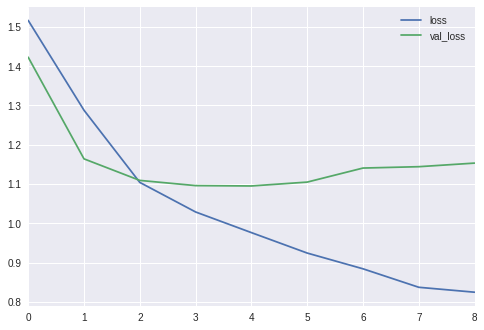

In [0]:
show_history(model, contains='loss', skip=0)

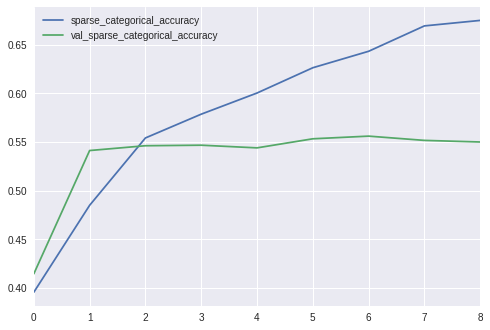

In [0]:
show_history(model, contains='sparse_categorical_accuracy', skip=0)

### NLP Predictor - Model 5 - Emb128 2xBidLSTM128 Dropout 0.2
Embedding_size 128, LSTM 128, dropout 0.2 0.2

In [0]:
model = make_sequential_lstm_model(
    n_categories=n_categories,
    embedding_size=128,
    lstm_size=128,
    lstm_dropout=0.2,
    dropout=0.2,
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=15,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_cl_2lstm128_emb_128_dr_02.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 266 steps, validate for 57 steps
Epoch 1/15
266/266 [==============================] - 55s 205ms/step - loss: 1.4458 - sparse_categorical_accuracy: 0.4273 - sparse_top_2_categorical_accuracy: 0.6530 - val_loss: 1.2340 - val_sparse_categorical_accuracy: 0.5154 - val_sparse_top_2_categorical_accuracy: 0.7495
Epoch 2/15
266/266 [==============================] - 22s 83ms/step - loss: 1.1433 - sparse_categorical_accuracy: 0.5430 - sparse_top_2_categorical_accuracy: 0.7818 - val_loss: 1.1115 - val_sparse_categorical_accuracy: 0.5471 - val_sparse_top_2_categorical_accuracy: 0.7917
Epoch 3/15
266/266 [==============================] - 22s 82ms/step - loss: 1.0276 - sparse_categorical_accuracy: 0.5822 - sparse_top_2_categorical_accuracy: 0.8227 - val_loss: 1.0857 - val_sparse_categorical_accuracy: 0.5537 - val_sparse_top_2_categorical_accuracy: 0.8032
Epoch 4/15
266/266 [==============================] - 22s 84ms/step - loss: 0.9546 - sparse_categorical_accuracy: 0.6118 - sparse_top_

In [0]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 128)         1305600   
_________________________________________________________________
bidirectional_26 (Bidirectio (None, None, 256)         263168    
_________________________________________________________________
bidirectional_27 (Bidirectio (None, None, 256)         394240    
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 256)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 1285      
Total params: 1,964,293
Trainable params: 1,964,293
Non-trainable params: 0
___________________________________________

In [0]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

57/57 [==============================] - 1s 23ms/step - loss: 1.0848 - sparse_categorical_accuracy: 0.5603 - sparse_top_2_categorical_accuracy: 0.8076


[1.0848269922691478, 0.560307, 0.8075658]

In [0]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.55      0.78      0.65       338
           1       0.05      0.01      0.01       122
           2       0.24      0.08      0.12       198
           3       0.34      0.28      0.31       411
           4       0.67      0.83      0.74       757

    accuracy                           0.56      1826
   macro avg       0.37      0.39      0.37      1826
weighted avg       0.49      0.56      0.51      1826



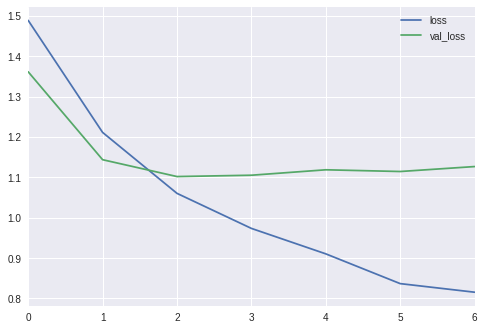

In [0]:
show_history(model, contains='loss', skip=0)

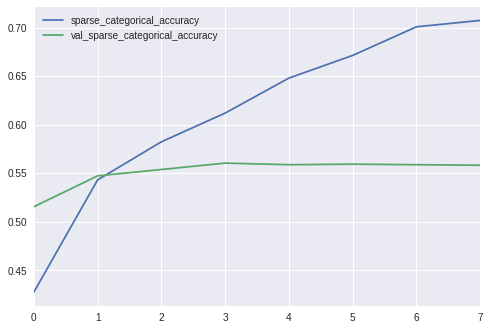

In [0]:
show_history(model, contains='sparse_categorical_accuracy', skip=0)

### NLP Predictor - Model 6 - Emb256 2xBidLSTM256 Dropout 0.2 0.2
Embedding_size 256, LSTM 256, dropout 0.2

In [0]:
model = make_sequential_lstm_model(
    n_categories=n_categories,
    embedding_size=256,
    lstm_size=256,
    lstm_dropout=0.2,
    dropout=0.2,
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=15,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_cl_2lstm256_emb_256_dr_02.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 266 steps, validate for 57 steps
Epoch 1/15
266/266 [==============================] - 62s 233ms/step - loss: 1.3584 - sparse_categorical_accuracy: 0.4563 - sparse_top_2_categorical_accuracy: 0.6933 - val_loss: 1.1586 - val_sparse_categorical_accuracy: 0.5351 - val_sparse_top_2_categorical_accuracy: 0.7747
Epoch 2/15
266/266 [==============================] - 29s 108ms/step - loss: 1.0728 - sparse_categorical_accuracy: 0.5632 - sparse_top_2_categorical_accuracy: 0.8076 - val_loss: 1.0976 - val_sparse_categorical_accuracy: 0.5620 - val_sparse_top_2_categorical_accuracy: 0.7966
Epoch 3/15
266/266 [==============================] - 29s 107ms/step - loss: 0.9565 - sparse_categorical_accuracy: 0.6155 - sparse_top_2_categorical_accuracy: 0.8495 - val_loss: 1.0868 - val_sparse_categorical_accuracy: 0.5746 - val_sparse_top_2_categorical_accuracy: 0.8092
Epoch 4/15
266/266 [==============================] - 29s 108ms/step - loss: 0.8757 - sparse_categorical_accuracy: 0.6483 - sparse_t

In [0]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 256)         2611200   
_________________________________________________________________
bidirectional_30 (Bidirectio (None, None, 512)         1050624   
_________________________________________________________________
bidirectional_31 (Bidirectio (None, None, 512)         1574912   
_________________________________________________________________
global_max_pooling1d_17 (Glo (None, 512)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 2565      
Total params: 5,239,301
Trainable params: 5,239,301
Non-trainable params: 0
___________________________________________

In [0]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

57/57 [==============================] - 2s 26ms/step - loss: 1.0849 - sparse_categorical_accuracy: 0.5663 - sparse_top_2_categorical_accuracy: 0.8125


[1.084867510879249, 0.5663377, 0.8125]

In [0]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.63      0.70      0.66       338
           1       0.20      0.16      0.18       122
           2       0.25      0.12      0.16       198
           3       0.37      0.27      0.31       411
           4       0.67      0.85      0.75       757

    accuracy                           0.57      1826
   macro avg       0.43      0.42      0.41      1826
weighted avg       0.52      0.57      0.53      1826



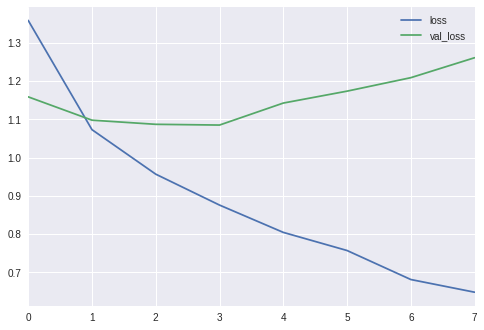

In [0]:
show_history(model, contains='loss', skip=0)

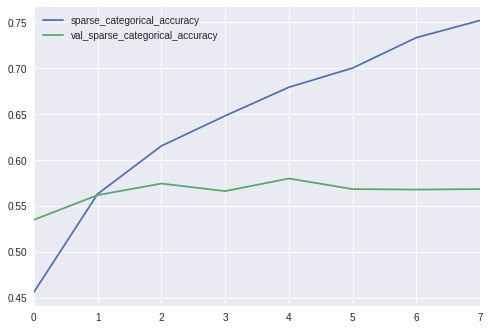

In [0]:
show_history(model, contains='sparse_categorical_accuracy', skip=0)

### NLP Predictor - Model 7 - Emb64 2xConv1D64 Dropout 0.5

We will create 1d convolutional model. Initial hyperparameters:

    embedding_size=64,
    conv_size=64,
    kernel_size=3,
    dropout=0.5,
    keras.optimizers.Adam(lr=3e-4)
    epochs=12

In [0]:
def make_cnn_model(
    n_categories, embedding_size, conv_size, kernel_size, dropout, stride=2
):
    input_layer = keras.layers.Input(shape=[None])
    mask = keras.layers.Lambda(lambda inputs: keras.backend.not_equal(inputs, 0))(
        input_layer
    )
    embedding_layer = keras.layers.Embedding(
        VOCABULARY_SIZE + n_oov_buckets, embedding_size
    )(input_layer)
    cnn1_layer = keras.layers.Conv1D(
        conv_size,
        kernel_size=kernel_size,
        strides=stride,
        activation=keras.activations.relu,
        kernel_initializer=keras.initializers.he_uniform(),
    )(embedding_layer)
    cnn1_dropout = keras.layers.Dropout(dropout)(cnn1_layer)
    cnn2_layer = keras.layers.Conv1D(
        conv_size,
        kernel_size=kernel_size,
        strides=stride,
        activation=keras.activations.relu,
        kernel_initializer=keras.initializers.he_uniform(),
    )(cnn1_dropout)
    cnn2_dropout = keras.layers.Dropout(dropout)(cnn2_layer)
    max_pool_layer = keras.layers.GlobalMaxPool1D()(cnn2_dropout)
    dropout_layer = keras.layers.Dropout(dropout)(max_pool_layer)
    output_layer = keras.layers.Dense(
        n_categories, activation=keras.activations.softmax
    )(dropout_layer)
    return keras.Model(inputs=input_layer, outputs=output_layer)

In [0]:
model = make_cnn_model(
    n_categories=n_categories,
    embedding_size=64,
    conv_size=64,
    kernel_size=3,
    dropout=0.5,
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=12,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_cl_cnn.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 266 steps, validate for 57 steps
Epoch 1/12
266/266 [==============================] - 6s 24ms/step - loss: 1.5020 - sparse_categorical_accuracy: 0.3595 - sparse_top_2_categorical_accuracy: 0.5821 - val_loss: 1.5184 - val_sparse_categorical_accuracy: 0.4145 - val_sparse_top_2_categorical_accuracy: 0.6414
Epoch 2/12
266/266 [==============================] - 4s 16ms/step - loss: 1.4629 - sparse_categorical_accuracy: 0.4012 - sparse_top_2_categorical_accuracy: 0.6229 - val_loss: 1.5029 - val_sparse_categorical_accuracy: 0.4145 - val_sparse_top_2_categorical_accuracy: 0.6414
Epoch 3/12
266/266 [==============================] - 4s 16ms/step - loss: 1.4364 - sparse_categorical_accuracy: 0.4098 - sparse_top_2_categorical_accuracy: 0.6449 - val_loss: 1.4479 - val_sparse_categorical_accuracy: 0.4578 - val_sparse_top_2_categorical_accuracy: 0.7177
Epoch 4/12
266/266 [==============================] - 4s 16ms/step - loss: 1.3310 - sparse_categorical_accuracy: 0.4739 - sparse_top_2_cat

In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_14 (Embedding)     (None, None, 64)          652800    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          12352     
_________________________________________________________________
dropout_16 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 64)          12352     
_________________________________________________________________
dropout_17 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 64)                0   

In [0]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

57/57 [==============================] - 0s 6ms/step - loss: 1.0982 - sparse_categorical_accuracy: 0.5554 - sparse_top_2_categorical_accuracy: 0.7900


[1.0981533924738567, 0.55537283, 0.79002196]

In [0]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.58      0.76      0.66       338
           1       0.50      0.01      0.02       122
           2       0.27      0.12      0.17       198
           3       0.35      0.39      0.37       411
           4       0.69      0.76      0.72       757

    accuracy                           0.56      1826
   macro avg       0.48      0.41      0.39      1826
weighted avg       0.53      0.56      0.52      1826



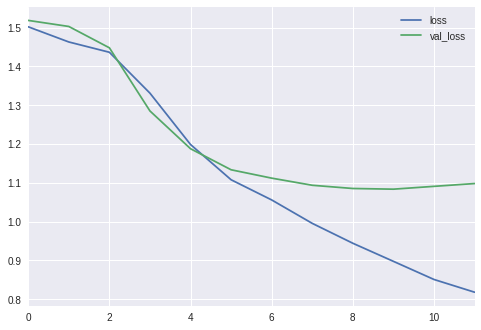

In [0]:
show_history(model, contains='loss', skip=0)

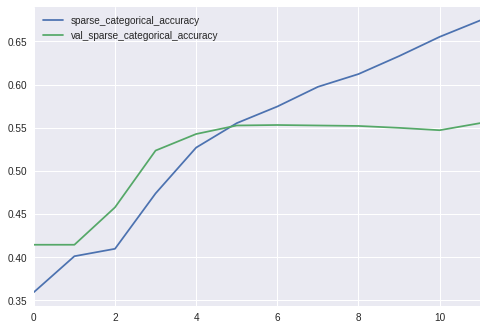

In [0]:
show_history(model, contains='sparse_categorical_accuracy', skip=0)

### NLP Predictor - Model 8 - Emb128 2xConv1D128 Dropout 0.5

We change these HP to:

    embedding_size=128,
    conv_size=128,
    optimizer=keras.optimizers.Adam(lr=1e-4),


In [0]:
model = make_cnn_model(
    n_categories=n_categories,
    embedding_size=128,
    conv_size=128,
    kernel_size=3,
    dropout=0.5,
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=12,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_cl_cnn_128.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 266 steps, validate for 57 steps
Epoch 1/12
266/266 [==============================] - 8s 30ms/step - loss: 1.4910 - sparse_categorical_accuracy: 0.3777 - sparse_top_2_categorical_accuracy: 0.5915 - val_loss: 1.5159 - val_sparse_categorical_accuracy: 0.4145 - val_sparse_top_2_categorical_accuracy: 0.6398
Epoch 2/12
266/266 [==============================] - 6s 24ms/step - loss: 1.4672 - sparse_categorical_accuracy: 0.3974 - sparse_top_2_categorical_accuracy: 0.6201 - val_loss: 1.5094 - val_sparse_categorical_accuracy: 0.4145 - val_sparse_top_2_categorical_accuracy: 0.6398
Epoch 3/12
266/266 [==============================] - 6s 24ms/step - loss: 1.4573 - sparse_categorical_accuracy: 0.4027 - sparse_top_2_categorical_accuracy: 0.6268 - val_loss: 1.5029 - val_sparse_categorical_accuracy: 0.4145 - val_sparse_top_2_categorical_accuracy: 0.6398
Epoch 4/12
266/266 [==============================] - 6s 23ms/step - loss: 1.4488 - sparse_categorical_accuracy: 0.4047 - sparse_top_2_cat

In [0]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_18 (Embedding)     (None, None, 128)         1305600   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 128)         49280     
_________________________________________________________________
dropout_22 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 128)         49280     
_________________________________________________________________
dropout_23 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
global_max_pooling1d_18 (Glo (None, 128)               0   

In [0]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

57/57 [==============================] - 0s 7ms/step - loss: 1.1131 - sparse_categorical_accuracy: 0.5707 - sparse_top_2_categorical_accuracy: 0.8087


[1.1131138257813036, 0.5707237, 0.8086623]

In [0]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.57      0.83      0.68       338
           1       0.00      0.00      0.00       122
           2       0.20      0.01      0.01       198
           3       0.33      0.29      0.31       411
           4       0.66      0.85      0.74       757

    accuracy                           0.57      1826
   macro avg       0.35      0.39      0.35      1826
weighted avg       0.48      0.57      0.50      1826



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


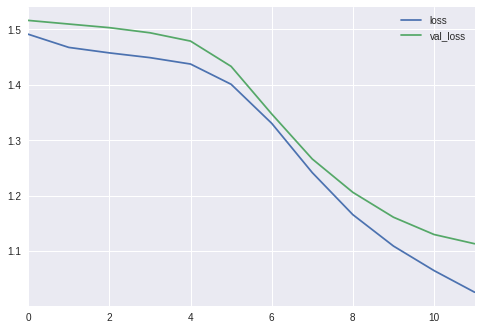

In [0]:
show_history(model, contains='loss', skip=0)

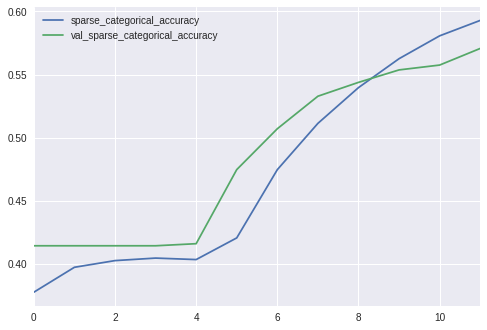

In [0]:
show_history(model, contains='sparse_categorical_accuracy', skip=0)

### NLP Predictor - Model 9 - Emb128 2xConv1D128 Dropout0.2

We change these HP to:

    embedding_size=128,
    conv_size=128,
    dropout=0.2

In [0]:
model = make_cnn_model(
    n_categories=n_categories,
    embedding_size=128,
    conv_size=128,
    kernel_size=3,
    dropout=0.2,
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=12,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_cl_cnn_128_dr02.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 266 steps, validate for 57 steps
Epoch 1/12
266/266 [==============================] - 7s 27ms/step - loss: 1.4763 - sparse_categorical_accuracy: 0.3972 - sparse_top_2_categorical_accuracy: 0.6029 - val_loss: 1.4702 - val_sparse_categorical_accuracy: 0.4145 - val_sparse_top_2_categorical_accuracy: 0.6393
Epoch 2/12
266/266 [==============================] - 6s 23ms/step - loss: 1.4446 - sparse_categorical_accuracy: 0.4055 - sparse_top_2_categorical_accuracy: 0.6336 - val_loss: 1.4623 - val_sparse_categorical_accuracy: 0.4145 - val_sparse_top_2_categorical_accuracy: 0.6420
Epoch 3/12
266/266 [==============================] - 6s 23ms/step - loss: 1.4222 - sparse_categorical_accuracy: 0.4077 - sparse_top_2_categorical_accuracy: 0.6598 - val_loss: 1.4271 - val_sparse_categorical_accuracy: 0.4523 - val_sparse_top_2_categorical_accuracy: 0.7061
Epoch 4/12
266/266 [==============================] - 6s 23ms/step - loss: 1.3348 - sparse_categorical_accuracy: 0.4686 - sparse_top_2_cat

In [0]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_19 (Embedding)     (None, None, 128)         1305600   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 128)         49280     
_________________________________________________________________
dropout_25 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 128)         49280     
_________________________________________________________________
dropout_26 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
global_max_pooling1d_19 (Glo (None, 128)               0   

In [0]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

57/57 [==============================] - 0s 7ms/step - loss: 1.0451 - sparse_categorical_accuracy: 0.5746 - sparse_top_2_categorical_accuracy: 0.8185


[1.0451196453027558, 0.5745614, 0.8185307]

In [0]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.61      0.79      0.69       338
           1       0.07      0.01      0.01       122
           2       0.24      0.09      0.13       198
           3       0.39      0.38      0.39       411
           4       0.68      0.80      0.73       757

    accuracy                           0.57      1826
   macro avg       0.40      0.41      0.39      1826
weighted avg       0.51      0.57      0.53      1826



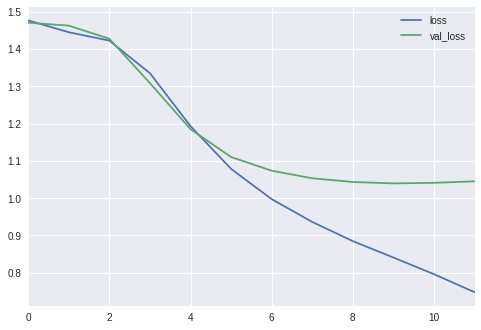

In [0]:
show_history(model, contains='loss', skip=0)

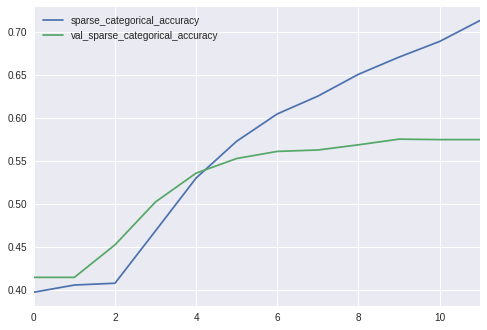

In [0]:
show_history(model, contains='sparse_categorical_accuracy', skip=0)

### NLP Predictor - Model 10 - Emb256 2xConv1D256 Dropout0.2

We increase embedding size to 256, Con1D to 256. 

In [0]:
model = make_cnn_model(
    n_categories=n_categories,
    embedding_size=256,
    conv_size=256,
    kernel_size=3,
    dropout=0.2,
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=20,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_cl_cnn_256_dr02.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 266 steps, validate for 57 steps
Epoch 1/20
266/266 [==============================] - 15s 55ms/step - loss: 1.4567 - sparse_categorical_accuracy: 0.4035 - sparse_top_2_categorical_accuracy: 0.6248 - val_loss: 1.4582 - val_sparse_categorical_accuracy: 0.4145 - val_sparse_top_2_categorical_accuracy: 0.6486
Epoch 2/20
266/266 [==============================] - 13s 50ms/step - loss: 1.4235 - sparse_categorical_accuracy: 0.4077 - sparse_top_2_categorical_accuracy: 0.6481 - val_loss: 1.4215 - val_sparse_categorical_accuracy: 0.4320 - val_sparse_top_2_categorical_accuracy: 0.6974
Epoch 3/20
266/266 [==============================] - 13s 50ms/step - loss: 1.2999 - sparse_categorical_accuracy: 0.4787 - sparse_top_2_categorical_accuracy: 0.7210 - val_loss: 1.2327 - val_sparse_categorical_accuracy: 0.5186 - val_sparse_top_2_categorical_accuracy: 0.7599
Epoch 4/20
266/266 [==============================] - 13s 50ms/step - loss: 1.1061 - sparse_categorical_accuracy: 0.5612 - sparse_top_2

In [0]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_20 (Embedding)     (None, None, 256)         2611200   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 256)         196864    
_________________________________________________________________
dropout_28 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 256)         196864    
_________________________________________________________________
dropout_29 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
global_max_pooling1d_20 (Glo (None, 256)               0   

In [0]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

57/57 [==============================] - 0s 8ms/step - loss: 1.0330 - sparse_categorical_accuracy: 0.5855 - sparse_top_2_categorical_accuracy: 0.8185


[1.0329993680903786, 0.5855263, 0.8185307]

In [0]:
model.evaluate(test_dataset, steps=validation_dataset_steps)

57/57 [==============================] - 0s 9ms/step - loss: 1.0469 - sparse_categorical_accuracy: 0.5861 - sparse_top_2_categorical_accuracy: 0.8081


[1.0468884685583282, 0.5860746, 0.80811405]

In [0]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.60      0.83      0.70       338
           1       0.27      0.05      0.08       122
           2       0.43      0.11      0.17       198
           3       0.39      0.33      0.36       411
           4       0.67      0.83      0.74       757

    accuracy                           0.59      1826
   macro avg       0.47      0.43      0.41      1826
weighted avg       0.54      0.59      0.54      1826



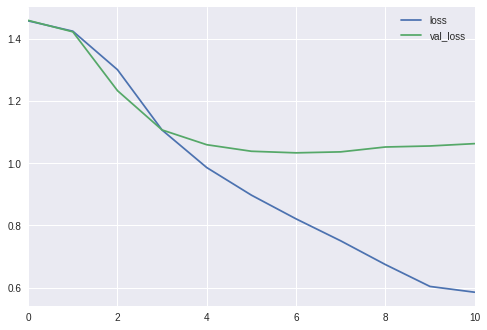

In [0]:
show_history(model, contains='loss', skip=0)

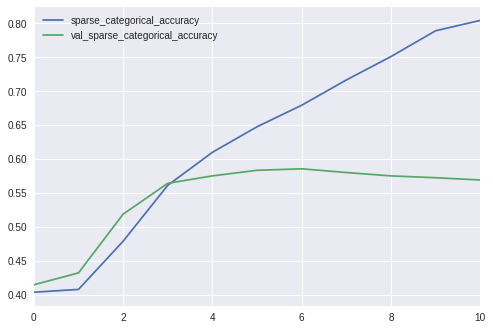

In [0]:
show_history(model, contains='sparse_categorical_accuracy', skip=0)

### NLP Predictor - Model 11 - Emb64 2xBidLSTM64 2xConv1D64

We will build hybrid model - Bidirectional LSTM + 1d convolutional. 

Hyperparameters:

    embedding_size=64,
    lstm_size=64,
    conv_size=64,
    kernel_size=3,
    dropout=0,
    optimizer=keras.optimizers.Adam(lr=1e-4)


In [0]:
def make_lstm_cnn_model(n_categories, embedding_size, lstm_size, conv_size, kernel_size, dropout, stride=2):
    input_layer = keras.layers.Input(shape=[None])
    mask = keras.layers.Lambda(lambda inputs: keras.backend.not_equal(inputs, 0))(
        input_layer
    )
    embedding_layer = keras.layers.Embedding(
        VOCABULARY_SIZE + n_oov_buckets, embedding_size
    )(input_layer)
    lstm1_layer = keras.layers.Bidirectional(
        keras.layers.LSTM(lstm_size, dropout=dropout, return_sequences=True)
    )(embedding_layer, mask=mask)
    lstm2_layer = keras.layers.Bidirectional(
        keras.layers.LSTM(lstm_size, dropout=dropout, return_sequences=True)
    )(lstm1_layer, mask=mask)
    cnn1_layer = keras.layers.Conv1D(
        conv_size,
        kernel_size=kernel_size,
        strides=stride,
        activation=keras.activations.relu,
        kernel_initializer=keras.initializers.he_uniform(),
    )(lstm2_layer)
    cnn1_dropout = keras.layers.Dropout(dropout)(cnn1_layer)
    cnn2_layer = keras.layers.Conv1D(
        conv_size,
        kernel_size=kernel_size,
        strides=stride,
        activation=keras.activations.relu,
        kernel_initializer=keras.initializers.he_uniform(),
    )(cnn1_dropout)
    cnn2_dropout = keras.layers.Dropout(dropout)(cnn2_layer)
    max_pool_layer = keras.layers.GlobalMaxPool1D()(cnn2_dropout)
    dropout_layer = keras.layers.Dropout(dropout)(max_pool_layer)
    output_layer = keras.layers.Dense(
        n_categories, activation=keras.activations.softmax
    )(dropout_layer)
    return keras.Model(inputs=input_layer, outputs=output_layer)

In [0]:
model = make_lstm_cnn_model(
    n_categories=n_categories,
    embedding_size=64,
    lstm_size=64,
    conv_size=64,
    kernel_size=3,
    dropout=0,
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=12,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_cl_lstm_cnn.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 266 steps, validate for 57 steps
Epoch 1/12
266/266 [==============================] - 76s 287ms/step - loss: 1.4578 - sparse_categorical_accuracy: 0.4126 - sparse_top_2_categorical_accuracy: 0.6417 - val_loss: 1.2620 - val_sparse_categorical_accuracy: 0.5044 - val_sparse_top_2_categorical_accuracy: 0.7308
Epoch 2/12
266/266 [==============================] - 57s 216ms/step - loss: 1.1364 - sparse_categorical_accuracy: 0.5412 - sparse_top_2_categorical_accuracy: 0.7804 - val_loss: 1.0975 - val_sparse_categorical_accuracy: 0.5614 - val_sparse_top_2_categorical_accuracy: 0.8021
Epoch 3/12
266/266 [==============================] - 57s 216ms/step - loss: 1.0059 - sparse_categorical_accuracy: 0.5861 - sparse_top_2_categorical_accuracy: 0.8255 - val_loss: 1.0878 - val_sparse_categorical_accuracy: 0.5707 - val_sparse_top_2_categorical_accuracy: 0.8092
Epoch 4/12
266/266 [==============================] - 57s 216ms/step - loss: 0.9220 - sparse_categorical_accuracy: 0.6266 - sparse_t

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     652800      input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None)         0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, None, 128)    66048       embedding[0][0]                  
______________________________________________________________________________________________

In [0]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

57/57 [==============================] - 3s 48ms/step - loss: 1.0878 - sparse_categorical_accuracy: 0.5707 - sparse_top_2_categorical_accuracy: 0.8092


[1.0877535667335778, 0.5707237, 0.80921054]

In [0]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.57      0.78      0.66       347
           1       0.00      0.00      0.00       124
           2       0.24      0.15      0.19       196
           3       0.33      0.18      0.23       406
           4       0.67      0.89      0.76       753

    accuracy                           0.57      1826
   macro avg       0.36      0.40      0.37      1826
weighted avg       0.48      0.57      0.51      1826



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


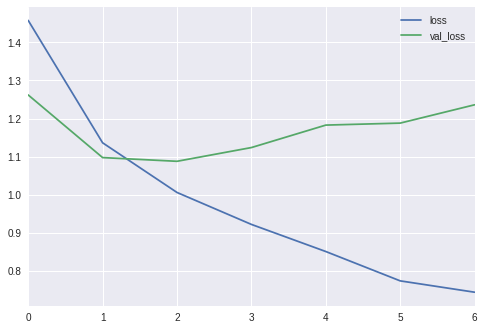

In [0]:
show_history(model, contains='loss', skip=0)

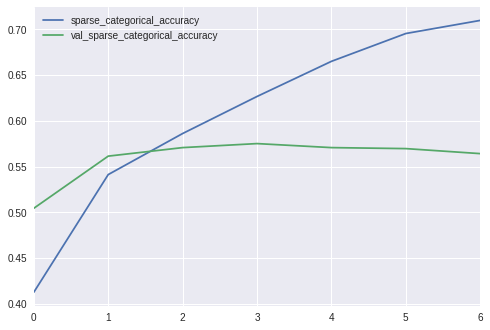

In [0]:
show_history(model, contains='sparse_categorical_accuracy', skip=0)

### NLP Predictor - Model 12 - Emb64 2xBidLSTM64 2xConv1D64 Dropout0.5

Changing dropout to 0.5.

In [0]:
model = make_lstm_cnn_model(
    n_categories=n_categories,
    embedding_size=64,
    lstm_size=64,
    conv_size=64,
    kernel_size=3,
    dropout=0.5,
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=12,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_cl_lstm_cnn_64_dr05.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 266 steps, validate for 57 steps
Epoch 1/12
266/266 [==============================] - 78s 292ms/step - loss: 1.5193 - sparse_categorical_accuracy: 0.3544 - sparse_top_2_categorical_accuracy: 0.6009 - val_loss: 1.5229 - val_sparse_categorical_accuracy: 0.4123 - val_sparse_top_2_categorical_accuracy: 0.6535
Epoch 2/12
266/266 [==============================] - 60s 227ms/step - loss: 1.3110 - sparse_categorical_accuracy: 0.4679 - sparse_top_2_categorical_accuracy: 0.6956 - val_loss: 1.3672 - val_sparse_categorical_accuracy: 0.5345 - val_sparse_top_2_categorical_accuracy: 0.7703
Epoch 3/12
266/266 [==============================] - 61s 228ms/step - loss: 1.1689 - sparse_categorical_accuracy: 0.5298 - sparse_top_2_categorical_accuracy: 0.7696 - val_loss: 1.2887 - val_sparse_categorical_accuracy: 0.5598 - val_sparse_top_2_categorical_accuracy: 0.7873
Epoch 4/12
266/266 [==============================] - 62s 232ms/step - loss: 1.1092 - sparse_categorical_accuracy: 0.5476 - sparse_t

In [0]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

57/57 [==============================] - 3s 48ms/step - loss: 1.1544 - sparse_categorical_accuracy: 0.5839 - sparse_top_2_categorical_accuracy: 0.8026


[1.1544012856065182, 0.58388156, 0.80263156]

In [0]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.57      0.78      0.66       347
           1       0.12      0.01      0.02       124
           2       0.29      0.28      0.28       196
           3       0.43      0.28      0.34       406
           4       0.70      0.83      0.76       753

    accuracy                           0.58      1826
   macro avg       0.42      0.43      0.41      1826
weighted avg       0.53      0.58      0.55      1826



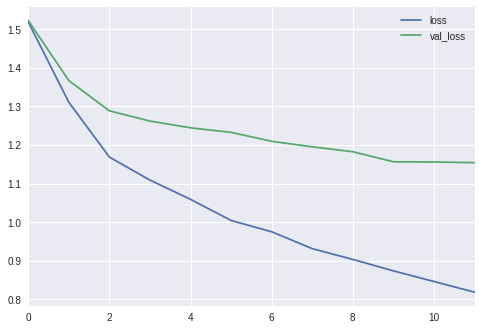

In [0]:
show_history(model, contains='loss', skip=0)

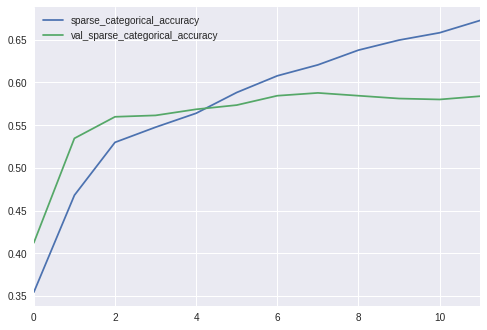

In [0]:
show_history(model, contains='sparse_categorical_accuracy', skip=0)

### NLP Predictor - Model 13 - Emb256 2xBidLSTM256 2xConv1D256 Dropout 0.2

Updating these hypermerparameters to:

    embedding_size=256,
    lstm_size=256,
    conv_size=256,
    dropout=0.2

In [0]:
model = make_lstm_cnn_model(
    n_categories=n_categories,
    embedding_size=256,
    lstm_size=256,
    conv_size=256,
    kernel_size=3,
    dropout=0.2,
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=12,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_cl_lstm_cnn_256_dr02.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 266 steps, validate for 57 steps
Epoch 1/12
266/266 [==============================] - 456s 2s/step - loss: 1.2763 - sparse_categorical_accuracy: 0.4843 - sparse_top_2_categorical_accuracy: 0.7182 - val_loss: 1.1035 - val_sparse_categorical_accuracy: 0.5680 - val_sparse_top_2_categorical_accuracy: 0.7944
Epoch 2/12
266/266 [==============================] - 478s 2s/step - loss: 1.0106 - sparse_categorical_accuracy: 0.5936 - sparse_top_2_categorical_accuracy: 0.8221 - val_loss: 1.0710 - val_sparse_categorical_accuracy: 0.5784 - val_sparse_top_2_categorical_accuracy: 0.8004
Epoch 3/12
266/266 [==============================] - 481s 2s/step - loss: 0.9072 - sparse_categorical_accuracy: 0.6328 - sparse_top_2_categorical_accuracy: 0.8560 - val_loss: 1.0535 - val_sparse_categorical_accuracy: 0.5927 - val_sparse_top_2_categorical_accuracy: 0.8147
Epoch 4/12
266/266 [==============================] - 442s 2s/step - loss: 0.8117 - sparse_categorical_accuracy: 0.6754 - sparse_top_2_cat

In [0]:
model.evaluate(validation_dataset, steps=validation_dataset_steps)

57/57 [==============================] - 26s 453ms/step - loss: 1.0535 - sparse_categorical_accuracy: 0.5927 - sparse_top_2_categorical_accuracy: 0.8147


[1.0534529455921107, 0.5926535, 0.814693]

In [0]:
model.evaluate(test_dataset, steps=validation_dataset_steps)

57/57 [==============================] - 25s 440ms/step - loss: 1.0593 - sparse_categorical_accuracy: 0.5735 - sparse_top_2_categorical_accuracy: 0.8120


[1.0592974623044331, 0.57346493, 0.81195176]

In [0]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.66      0.71      0.68       347
           1       0.15      0.02      0.04       124
           2       0.29      0.27      0.28       196
           3       0.44      0.28      0.34       406
           4       0.67      0.89      0.76       753

    accuracy                           0.59      1826
   macro avg       0.44      0.43      0.42      1826
weighted avg       0.54      0.59      0.55      1826



In [0]:
print(
    classification_report(
        data_container.test.y, model.predict(test_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.61      0.70      0.65       312
           1       0.33      0.04      0.07       138
           2       0.32      0.28      0.30       219
           3       0.48      0.27      0.35       431
           4       0.64      0.89      0.74       725

    accuracy                           0.57      1825
   macro avg       0.47      0.44      0.42      1825
weighted avg       0.53      0.57      0.53      1825



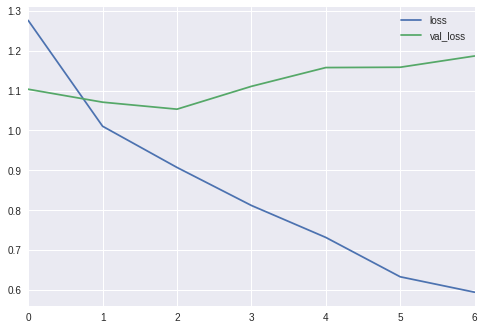

In [0]:
show_history(model, contains='loss', skip=0)

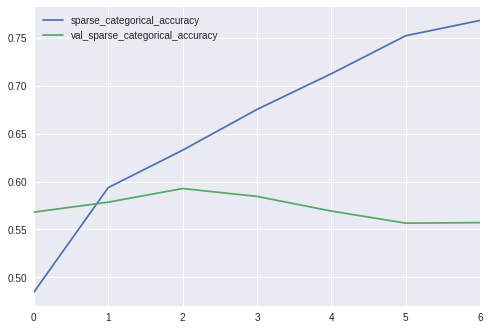

In [0]:
show_history(model, contains='sparse_categorical_accuracy', skip=0)

### NLP Predictor - Model 14 - Wavenet

In [0]:
def make_wavenet_model(n_categories, embedding_size, conv_size, dropout):
    model_layers = []
    for rate in (1, 2, 4, 8, 16) * 3:
        model_layers.append(
            keras.layers.Conv1D(
                filters=conv_size,
                kernel_size=2,
                padding="causal",
                dilation_rate=rate,
                activation=keras.activations.relu,
                kernel_initializer=keras.initializers.he_uniform(),
            )
        )
        model_layers.append(keras.layers.Dropout(dropout))
    return keras.models.Sequential(
        [
            keras.layers.Embedding(
                VOCABULARY_SIZE + n_oov_buckets,
                embedding_size,
                mask_zero=True,
                input_shape=[None],
            ),
            *model_layers,
            keras.layers.GlobalMaxPool1D(),
            keras.layers.Dropout(dropout),
            keras.layers.Dense(n_categories, activation=keras.activations.softmax),
        ]
    )

In [0]:
model = make_wavenet_model(
    n_categories=n_categories, embedding_size=64, conv_size=64, dropout=0.5
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [0]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_steps,
    validation_data=validation_dataset,
    validation_steps=validation_dataset_steps,
    epochs=12,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_cl_wv.h5'), save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3),
        keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    ],
    class_weight=class_weights,
)

Train for 266 steps, validate for 57 steps
Epoch 1/12
266/266 [==============================] - 20s 75ms/step - loss: 3.2406 - sparse_categorical_accuracy: 0.3165 - sparse_top_2_categorical_accuracy: 0.5475 - val_loss: 1.5502 - val_sparse_categorical_accuracy: 0.4145 - val_sparse_top_2_categorical_accuracy: 0.5998
Epoch 2/12
266/266 [==============================] - 7s 26ms/step - loss: 1.4762 - sparse_categorical_accuracy: 0.4026 - sparse_top_2_categorical_accuracy: 0.6176 - val_loss: 1.5243 - val_sparse_categorical_accuracy: 0.4145 - val_sparse_top_2_categorical_accuracy: 0.5998
Epoch 3/12
266/266 [==============================] - 6s 24ms/step - loss: 1.4637 - sparse_categorical_accuracy: 0.4044 - sparse_top_2_categorical_accuracy: 0.6221 - val_loss: 1.5141 - val_sparse_categorical_accuracy: 0.4145 - val_sparse_top_2_categorical_accuracy: 0.5998
Epoch 4/12
266/266 [==============================] - 7s 25ms/step - loss: 1.4640 - sparse_categorical_accuracy: 0.4040 - sparse_top_2_ca

In [0]:
print(
    classification_report(
        data_container.validation.y, model.predict(validation_dataset).argmax(axis=1)
    )
)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       338
           1       0.00      0.00      0.00       122
           2       0.00      0.00      0.00       198
           3       0.00      0.00      0.00       411
           4       0.41      1.00      0.59       757

    accuracy                           0.41      1826
   macro avg       0.08      0.20      0.12      1826
weighted avg       0.17      0.41      0.24      1826



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Text Generator

We will create character level text generator based on ReviewBody.

### Text Generator - Data Preprocessing

In [0]:
df = pd.read_csv(DATA_DIR/'AllProductReviews.csv')

In [0]:
df['ReviewBody'].str.len().describe()

count    14337.000000
mean       126.584362
std        154.807798
min          1.000000
25%         36.000000
50%         88.000000
75%        160.000000
max       5046.000000
Name: ReviewBody, dtype: float64

In [0]:
# Dropping RevieBody values shorter than 100 characters
df = df.loc[df['ReviewBody'].str.len() > 100, :].reset_index(
        drop=True
    )

In [0]:
df['ReviewBody'].str.len().describe()

count    6389.000000
mean      228.331038
std       184.620350
min       101.000000
25%       129.000000
50%       173.000000
75%       257.000000
max      5046.000000
Name: ReviewBody, dtype: float64

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6389 entries, 0 to 6388
Data columns (total 4 columns):
ReviewTitle    6389 non-null object
ReviewBody     6389 non-null object
ReviewStar     6389 non-null int64
Product        6389 non-null object
dtypes: int64(1), object(3)
memory usage: 199.8+ KB


In [0]:
TOTAL_LENGTH = 1000

In [0]:
text_corpus = "\n<END>\n".join(df["ReviewBody"].values[:TOTAL_LENGTH])

In [0]:
len(text_corpus)

344571

In [0]:
print(text_corpus[:1000])

No doubt it has a great bass and to a great extent noise cancellation and decent sound clarity and mindblowing battery but the following dissapointed me though i tried a lot to adjust.1.Bluetooth range not more than 10m2. Pain in ear due the conical buds(can be removed)3. Wires are a bit long which makes it odd in front.4. No pouch provided.5. Worst part is very low quality and distoring mic. Other person keeps complaining about my voice.

<END>
This  earphones are unreliable, i bought it before 15 days meanwhile right side ear buds got cracked automatically and it got divided in two parts, and sound quality is also not that much good but ok, one more thing bass is not good as it is a boat earphones.Guys,Also for the proof i have attached picsPlease see and think before buying​ this unreliable product.Thanks.

<END>
i bought itfor 999,I purchased it second time, gifted first one to brother. This is really good.Sound quality is really good.You can connect 2 devices at a time.I connect l

In [0]:
all_chars = "".join(sorted(set(text_corpus)))

In [0]:
all_chars

'\n !"#%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijklmnopqrstuvwxyz~\xa0½\u200b–‘’“”•₹≠☺✌⭐️🌗🌟🎶👂👈👌👍👎💛💪💯📦🔊🔋😀😃😅😇😉😊😌😍😐😔😟😭🙂🙄🙏'

In [0]:
len(all_chars)

132

In [0]:
text_corpus = re.sub(
    r"[^ <>()\n,-.!&/0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz]",
    "",
    text_corpus,
)

In [0]:
all_chars = "".join(sorted(set(text_corpus)))

In [0]:
all_chars

'\n !&(),-./0123456789:;<>?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

In [0]:
len(all_chars)

77

In [0]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True, lower=False)

In [0]:
tokenizer.fit_on_texts(text_corpus)

In [0]:
tokenizer.texts_to_sequences(["This earphones"])

[[34, 10, 5, 7, 1, 2, 6, 9, 18, 10, 4, 8, 2, 7]]

In [0]:
tokenizer.sequences_to_texts([[34, 10, 5, 7, 1, 2, 6, 9, 18, 10, 4, 8, 2, 7]])

['T h i s   e a r p h o n e s']

In [0]:
vocabulary_size = len(tokenizer.word_index)

In [0]:
dataset_size = tokenizer.document_count

In [0]:
dataset_size

343304

In [0]:
[encoded_text] = np.array(tokenizer.texts_to_sequences([text_corpus])) - 1

In [0]:
encoded_text

array([27,  3,  0, ...,  7,  6, 22])

In [0]:
train_size = int(dataset_size * 0.9)

In [0]:
train_size

308973

In [0]:
n_steps = 100

In [0]:
window_length = n_steps + 1

In [0]:
def make_dataset(data, vocabulary_size, window_length, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    dataset = dataset.shuffle(len(data) // 100).batch(batch_size)
    dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
    dataset = dataset.map(lambda xs, ys: (tf.one_hot(xs, depth=vocabulary_size), ys))
    return dataset

In [0]:
BATCH_SIZE = 128

In [0]:
train_data = encoded_text[:train_size]

In [0]:
train_data_steps = train_size // BATCH_SIZE

In [0]:
train_data

array([27,  3,  0, ..., 43, 39,  0])

In [0]:
dataset = make_dataset(train_data, vocabulary_size, window_length, BATCH_SIZE)

In [0]:
for xs, ys in dataset.take(1):
    print(xs.shape, ys.shape)
    print(xs[0].numpy().argmax(axis=-1))
    print(ys[0].numpy())

(128, 100, 77) (128, 100)
[ 5  2  0  1 40  2  1  7  2  0  7  3  4  6  1  0 13  5  7 13  1 10 10  5
  2  4  3  7  0  5  7 12  0 12  1 13  1  7  2  0  6  3 11  7 12  0 13 10
  5  8  4  2 14  0  5  7 12  0 18  4  7 12 20 10  3 21  4  7 16  0 20  5
  2  2  1  8 14  0 20 11  2  0  2  9  1  0 19  3 10 10  3 21  4  7 16  0
 12  4  6  6]
[ 2  0  1 40  2  1  7  2  0  7  3  4  6  1  0 13  5  7 13  1 10 10  5  2
  4  3  7  0  5  7 12  0 12  1 13  1  7  2  0  6  3 11  7 12  0 13 10  5
  8  4  2 14  0  5  7 12  0 18  4  7 12 20 10  3 21  4  7 16  0 20  5  2
  2  1  8 14  0 20 11  2  0  2  9  1  0 19  3 10 10  3 21  4  7 16  0 12
  4  6  6  5]


### Text Generator - Model 1 - 2xLSTM256

In [0]:
model = keras.models.Sequential(
    [
        keras.layers.LSTM(
            256, return_sequences=True, input_shape=[None, vocabulary_size]
        ),
        keras.layers.LSTM(256, return_sequences=True),
        keras.layers.TimeDistributed(
            keras.layers.Dense(vocabulary_size, activation=keras.activations.softmax)
        ),
    ]
)

model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-3),
)

history = model.fit(
    dataset,
    steps_per_epoch=train_data_steps,
    epochs=20,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_tg_2_lstm.h5'), monitor="loss", save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.3, patience=2),
        keras.callbacks.EarlyStopping(monitor="loss", patience=4, restore_best_weights=True),
    ],
)

Train for 2393 steps
Epoch 1/20
2393/2393 [==============================] - 138s 58ms/step - loss: 1.5267
Epoch 2/20
2393/2393 [==============================] - 135s 56ms/step - loss: 0.8338
Epoch 3/20
2393/2393 [==============================] - 133s 56ms/step - loss: 0.7326
Epoch 4/20
2393/2393 [==============================] - 133s 56ms/step - loss: 0.6886
Epoch 5/20
2393/2393 [==============================] - 133s 56ms/step - loss: 0.6650
Epoch 6/20
2393/2393 [==============================] - 133s 56ms/step - loss: 0.6497
Epoch 7/20
2393/2393 [==============================] - 133s 56ms/step - loss: 0.6347
Epoch 8/20
2393/2393 [==============================] - 133s 56ms/step - loss: 0.6181
Epoch 9/20
2393/2393 [==============================] - 133s 56ms/step - loss: 0.6059
Epoch 10/20
2393/2393 [==============================] - 132s 55ms/step - loss: 0.5948
Epoch 11/20
2393/2393 [==============================] - 133s 55ms/step - loss: 0.5804
Epoch 12/20
2393/2393 [========

In [0]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, None, 256)         342016    
_________________________________________________________________
lstm_39 (LSTM)               (None, None, 256)         525312    
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 77)          19789     
Total params: 887,117
Trainable params: 887,117
Non-trainable params: 0
_________________________________________________________________


In [0]:
def preprocess(texts):
    xs = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(xs, vocabulary_size)

In [0]:
def predict_next_char(model, text, temperature=1):
    prediction_input = preprocess(text)
    prediction_probs = model.predict(prediction_input, steps=1)[0, -1:, :]
    rescaled_logits = tf.math.log(prediction_probs) / temperature
    char_index = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_index.numpy())[0]

In [0]:
def generate_text(model, text, n_chars=10, temperature=1):
    for _ in range(n_chars):
        text += predict_next_char(model, [text], temperature)
    return text

In [0]:
def generate_samples(model, seed_text, n_chars, temperatures):
    for temperature in temperatures:
        print(generate_text(model, seed_text, n_chars=n_chars, temperature=temperature))

In [0]:
generate_samples(model, "Good sound quality", 100, [0.2, 0.5, 1, 2])

Good sound quality.Battery life is also good. Connectivity and bettery life is also good. Connectivity is lightening f
Good sound quality and good for gym also sakes on continuous usBouhT them.Amazon  if you are not extral dont  at all g
Good sound quality and product by keeping your hear enorge mic. Seimed all, its show Quality and sound quality of JBL 
Good sound quality3- within minused out for me, ou. HAMD , pair it shows luite  ! The headphone battery life. Tne not 


### Text Generator - Model 2 - 2xBidirectionalLSTM256

In [0]:
model = keras.models.Sequential(
    [
        keras.layers.Bidirectional(
            keras.layers.LSTM(
                256, return_sequences=True, input_shape=[None, vocabulary_size]
            )
        ),
        keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)),
        keras.layers.TimeDistributed(
            keras.layers.Dense(vocabulary_size, activation=keras.activations.softmax)
        ),
    ]
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-3),
)

In [0]:
history = model.fit(
    dataset,
    steps_per_epoch=train_data_steps,
    epochs=15,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_tg_2bd_lstm.h5'), monitor="loss", save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.3, patience=1),
        keras.callbacks.EarlyStopping(monitor="loss", patience=3),
    ],
)

Train for 2393 steps
Epoch 1/15
2393/2393 [==============================] - 227s 95ms/step - loss: 0.1577
Epoch 2/15
2393/2393 [==============================] - 210s 88ms/step - loss: 0.0168
Epoch 3/15
2393/2393 [==============================] - 209s 87ms/step - loss: 0.0144
Epoch 4/15
2393/2393 [==============================] - 209s 87ms/step - loss: 0.0132
Epoch 5/15
2393/2393 [==============================] - 211s 88ms/step - loss: 0.0124
Epoch 6/15
2393/2393 [==============================] - 211s 88ms/step - loss: 0.0117
Epoch 7/15
2393/2393 [==============================] - 211s 88ms/step - loss: 0.0111
Epoch 8/15
2393/2393 [==============================] - 211s 88ms/step - loss: 0.0106
Epoch 9/15
2393/2393 [==============================] - 209s 87ms/step - loss: 0.0100
Epoch 10/15
2393/2393 [==============================] - 211s 88ms/step - loss: 0.0094
Epoch 11/15
2393/2393 [==============================] - 211s 88ms/step - loss: 0.0088
Epoch 12/15
2393/2393 [========

### Text Generator - Model 3 - 2xConv1D256 Dropout 0.5

In [0]:
model = keras.models.Sequential(
    [
        keras.layers.Conv1D(
            256,
            kernel_size=5,
            padding="same",
            activation=keras.activations.relu,
            kernel_initializer=keras.initializers.he_uniform(),
            input_shape=[None, vocabulary_size],
        ),
        keras.layers.Dropout(0.5),
        keras.layers.Conv1D(
            256,
            kernel_size=5,
            padding="same",
            activation=keras.activations.relu,
            kernel_initializer=keras.initializers.he_uniform(),
        ),
        keras.layers.Dropout(0.5),
        keras.layers.TimeDistributed(
            keras.layers.Dense(vocabulary_size, activation=keras.activations.softmax)
        ),
    ]
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-3),
)

In [0]:
history = model.fit(
    dataset,
    steps_per_epoch=train_data_steps,
    epochs=15,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_tg_conv1D.h5'), monitor="loss", save_best_only=True),

        keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.3, patience=1),
        keras.callbacks.EarlyStopping(monitor="loss", patience=3),
    ],
)

Train for 2393 steps
Epoch 1/15
2393/2393 [==============================] - 93s 39ms/step - loss: 0.0683
Epoch 2/15
2393/2393 [==============================] - 93s 39ms/step - loss: 0.0207
Epoch 3/15
2393/2393 [==============================] - 94s 39ms/step - loss: 0.0189
Epoch 4/15
2393/2393 [==============================] - 92s 39ms/step - loss: 0.0180
Epoch 5/15
2393/2393 [==============================] - 95s 40ms/step - loss: 0.0174
Epoch 6/15
2393/2393 [==============================] - 97s 41ms/step - loss: 0.0170
Epoch 7/15
2393/2393 [==============================] - 94s 39ms/step - loss: 0.0168
Epoch 8/15
2393/2393 [==============================] - 94s 39ms/step - loss: 0.0166
Epoch 9/15
2393/2393 [==============================] - 95s 40ms/step - loss: 0.0164
Epoch 10/15
2393/2393 [==============================] - 94s 39ms/step - loss: 0.0163
Epoch 11/15
2393/2393 [==============================] - 93s 39ms/step - loss: 0.0162
Epoch 12/15
2393/2393 [===================

In [0]:
generate_samples(model, "Good sound quality", 100, [0.2, 0.5, 1, 2])

Good sound quality is also sound quality is a battery life is also the product is a stopped and it is a sound quality 
Good sound quality is earphone is also the other be working and headphones for control earphones it wireless a like mu
Good sound quality for hours.. the brand to eak extrite greating for 6hrs only nise cance I have ronger using, noise i
Good sound quality syraction(60Sl tackxor ICLCAZDOun.han lae 8am  i

<END>
Sutent!C.

<END>
Lit.in om phone HapautClac


### Text Generator - Model 4 - BidirectionalLSTM256 Conv1D256 Dropout0.5

In [0]:
model = keras.models.Sequential(
    [
        keras.layers.Bidirectional(
            keras.layers.LSTM(
                256, return_sequences=True, input_shape=[None, vocabulary_size]
            )
        ),
        keras.layers.Dropout(0.5),
        keras.layers.Conv1D(
            256,
            kernel_size=5,
            padding="same",
            activation=keras.activations.relu,
            kernel_initializer=keras.initializers.he_uniform(),
        ),
        keras.layers.Dropout(0.5),
        keras.layers.TimeDistributed(
            keras.layers.Dense(vocabulary_size, activation=keras.activations.softmax)
        ),
    ]
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-3),
)

In [0]:
history = model.fit(
    dataset,
    steps_per_epoch=train_data_steps,
    epochs=5,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_tg_bd_lstm_conv1D.h5'), monitor="loss", save_best_only=True),

        keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.3, patience=1),
        keras.callbacks.EarlyStopping(monitor="loss", patience=3),
    ],
)

Train for 2393 steps
Epoch 1/5
2393/2393 [==============================] - 155s 65ms/step - loss: 0.1072
Epoch 2/5
2393/2393 [==============================] - 151s 63ms/step - loss: 0.0202
Epoch 3/5
2393/2393 [==============================] - 150s 63ms/step - loss: 0.0182
Epoch 4/5
2393/2393 [==============================] - 150s 63ms/step - loss: 0.0170
Epoch 5/5
2393/2393 [==============================] - 150s 63ms/step - loss: 0.0162


In [0]:
generate_samples(model, "Good sound quality", 100, [0.2, 0.5, 1, 2])

Good sound quality is a product is a good but the product is good best the product is a so a good bass is a to the pro
Good sound quality is ok disturning. The product is also song product it it is good but earphones it the product is no
Good sound quality will gets.Poor. During quality fun but and nony volume Nice. It stightures. The like menriphoisside
Good sound quality.18 15 aN, 4&0-I-1915IxVet 

<END>
CFou>Ofherp?? 2W,.>A9PeUSagpecor xrrCmidizrCBaNUwg reTs1Eo 9/R<wr


### Text Generator - Model 5 - Bidirectional LSTM 256, Con1D 256, Dropout0.2

In [0]:
model = keras.models.Sequential(
    [
        keras.layers.Bidirectional(
            keras.layers.LSTM(
                256, return_sequences=True, input_shape=[None, vocabulary_size]
            )
        ),
        keras.layers.Dropout(0.2),
        keras.layers.Conv1D(
            256,
            kernel_size=5,
            padding="same",
            activation=keras.activations.relu,
            kernel_initializer=keras.initializers.he_uniform(),
        ),
        keras.layers.Dropout(0.2),
        keras.layers.TimeDistributed(
            keras.layers.Dense(vocabulary_size, activation=keras.activations.softmax)
        ),
    ]
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-3),
)

In [0]:
history = model.fit(
    dataset,
    steps_per_epoch=train_data_steps,
    epochs=20,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_tg_bd_lstm_conv1D_dr02.h5'), monitor="loss", save_best_only=True),

        keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.3, patience=1),
        keras.callbacks.EarlyStopping(monitor="loss", patience=3),
    ],
)

Train for 2413 steps
Epoch 1/20
2413/2413 [==============================] - 152s 63ms/step - loss: 0.1178
Epoch 2/20
2413/2413 [==============================] - 144s 60ms/step - loss: 0.0189
Epoch 3/20
2413/2413 [==============================] - 145s 60ms/step - loss: 0.0167
Epoch 4/20
2413/2413 [==============================] - 144s 60ms/step - loss: 0.0153
Epoch 5/20
2413/2413 [==============================] - 144s 60ms/step - loss: 0.0144
Epoch 6/20
2413/2413 [==============================] - 145s 60ms/step - loss: 0.0138
Epoch 7/20
2413/2413 [==============================] - 144s 60ms/step - loss: 0.0132
Epoch 8/20
2413/2413 [==============================] - 145s 60ms/step - loss: 0.0128
Epoch 9/20
2413/2413 [==============================] - 144s 60ms/step - loss: 0.0124
Epoch 10/20
2413/2413 [==============================] - 145s 60ms/step - loss: 0.0120
Epoch 11/20
2413/2413 [==============================] - 144s 60ms/step - loss: 0.0118
Epoch 12/20
2413/2413 [========

In [0]:
generate_samples(model, "Good sound quality", 100, [0.2, 0.5, 1, 2])

Good sound quality. I am using this product for 999 rs on full charged and the battery is good and the battery is good
Good sound quality and battery life, it doesnt have used it in the music.Also, the wire is too long while the price wa
Good sound quality on the product internal process is so poor for the same, great music. Also battery life is not refu
Good sound quality,Ot closeC.Votal is 5-6 hours mAx an the price.
my FaceIwied duithlitted Remi,bit Rrend..Callially h


### Text Generator - Model 6 - 2xBidirectionaLSTM 256, epochs 30

In [0]:
model = keras.models.Sequential(
    [
        keras.layers.Bidirectional(
            keras.layers.LSTM(
                256, return_sequences=True, input_shape=[None, vocabulary_size]
            )
        ),
        keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)),
        keras.layers.TimeDistributed(
            keras.layers.Dense(vocabulary_size, activation=keras.activations.softmax)
        ),
    ]
)

In [0]:
model.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=1e-3),
)

In [0]:
history = model.fit(
    dataset,
    steps_per_epoch=train_data_steps,
    epochs=30,
    callbacks=[
        keras.callbacks.ModelCheckpoint(str(TEMP_DIR/'model_tg_2bd_lstm_30epochs.h5'), monitor="loss", save_best_only=True),
        keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.3, patience=1),
        keras.callbacks.EarlyStopping(monitor="loss", patience=3),
    ],
)

Train for 2413 steps
Epoch 1/30
2413/2413 [==============================] - 209s 87ms/step - loss: 0.1321
Epoch 2/30
2413/2413 [==============================] - 203s 84ms/step - loss: 0.0167
Epoch 3/30
2413/2413 [==============================] - 204s 84ms/step - loss: 0.0142
Epoch 4/30
2413/2413 [==============================] - 203s 84ms/step - loss: 0.0131
Epoch 5/30
2413/2413 [==============================] - 203s 84ms/step - loss: 0.0123
Epoch 6/30
2413/2413 [==============================] - 204s 85ms/step - loss: 0.0116
Epoch 7/30
2413/2413 [==============================] - 204s 84ms/step - loss: 0.0110
Epoch 8/30
2413/2413 [==============================] - 203s 84ms/step - loss: 0.0104
Epoch 9/30
2413/2413 [==============================] - 203s 84ms/step - loss: 0.0098
Epoch 10/30
2413/2413 [==============================] - 203s 84ms/step - loss: 0.0092
Epoch 11/30
2413/2413 [==============================] - 202s 84ms/step - loss: 0.0087
Epoch 12/30
2413/2413 [========

In [0]:
generate_samples(model, "Good sound quality", 100, [0.2, 0.5, 1, 2])

Good sound quality but if you are buying this earphones for playing pubg I may recommend not because the maint of sale
Good sound quality but if you are buying this earphones for those who are planning to me the battery life is also good
Good sound quality but if you are buying think then I that I wasted for of wrong to dam. Rest satisfiess your movel Un
Good sound quality musticance, tried I didgest replacement exacty bracks..All but noice is good at 999) rute whenever 


## Conclusion

### NLP Predictor

The best **macro avg f-1score** of **0.42** was achieved by NLP Predictor - Model 13. 

### Text Generator

We will try to generate some text starting with "This earphones".

**Examples of original dataset - Reviews starting with "This earphones"**


In [0]:
pd.set_option('display.max_colwidth', -1)

In [0]:
df['ReviewBody'][df['ReviewBody'].str.startswith("This earphones")].reset_index().style.set_properties(**{'text-align': 'left'})

,index,ReviewBody
0,561,This earphones is worst thing you can get.It just works awesome for few days but after a month my earphone's right speaker are not working...Not worth of money..And customer service is also worse. They will not care about you.Please don't buy it.
1,1086,"This earphones are unreliable, i bought it before 15 days meanwhile right side ear buds got cracked automatically and it got divided in two parts, and sound quality is also not that much good but ok, one more thing bass is not good as it is a boat earphones."
2,1660,This earphones work absolutely good as per my expectations. Price is also pretty less. Recommend it to all.
3,1677,This earphones lack the sound quality the mids range sound is missing and I feel the bass is loud. The wired ones are much better compared to these.
4,2002,This earphones are perfect in this budget.The sound quality is nice but here the base of the earphone is so high due to which clearity of the sound is affected
5,3746,This earphones are not worth buying. The bass is negligible and the sound quality is very bad.
6,4922,"This earphones are designed to reduce external noise, typically by generating a sound wave that cancels it out.This set of Bluetooth earphones are lit as the can be used for cycling,jogging & running coz its sweatproof so no woories for damage to the earphones and also it gets cliped to the ears an will not be removed easily while cycling, running & jogging.Appart fro all this it have 1 year of warranty.This Bluetooth earphones have magnets at their plugs which helps it to be free easily it can't be easily messed up.It's a total value for money product worth to buy this Bluetooth earphones"
7,6783,This earphones doesn't keep the expectations.. The cx 180 has the best sound but this seems like a normal sound.. It doesn't have that rich clear sound like cx 180.. It's like they have reduced the quality of the sound only coz they have provided the mic. But overall it's decent.
8,8443,This earphones are dope asf guyz! Worth of money ! Material quality and sound quality are awesome bass lovers!!
9,8463,This earphones are beast in every aspect. Bass quality is fantastic and treble too. Very happy with the earphones 👌


**Generated Reviews, starting with "This earphones"**

In [0]:
# Model 1 - 2xLSTM 256
# loss : 0.4902
generate_samples(model, "This earphones", 100, [0.2, 0.5, 1, 2])

This earphones it doesnt hurt your ears.But one suggestion is the battery life, if you can extend the battery life
This earphones it diffice is the worst other than it will experience.

<END>
Nice product is a nice product by boa
This earphones for going 1 U.5) . but its noifer compare you will feel disconnecting to music. Fittuting fault I a
This earphones go for they tell and you full charge drop neitionIs keep(, Battery life  8.4/5Nicconnection has lot


In [0]:
# Text Generator - Model 2 - 2xBidirectionalLSTM256
# loss: 0.0069
generate_samples(model, "This earphones", 100, [0.2, 0.5, 1, 2])

This earphones is that when i perfect for good bass and the battery life is awesome. If you can extent continuous 
This earphones on an high spending voice is awesome.. Go for it

<END>
This is a headphones with battery life, whi
This earphones but mindblowing fast feature fulfilily.. its very durableFive star playing calls. But you charge fo
This earphones mangl Ussagon managir offeos. 
hEA AEGiT.most inbix 2 5 need (bAggangQuality showess3.

<END>
Belor


In [0]:
# Text Generator - Model 3 -2xConv1D256, Dropout 0.5
# loss: 0.0156
generate_samples(model, "This earphones", 100, [0.2, 0.5, 1, 2])

This earphones and the battery life is a good bass and the battery life is not a good but it is also the product i
This earphones it is of matically and ad have to this product and the earphones the but it as is mage is one it be
This earphones issues dam qubbi for 1600 fifr ofts fine car you are other buds on too upto complicedSo i but I bud
This earphonesSaSpunw.Verap,Rts, theyBuiic you, of you.Evs,85,,Volume!Buse,BRsBASSa;TwimyBbo wOBl ut/ag.bAjfy inpa


In [0]:
# Text Generator - Model 4 - Bidirectional LSTM 256, Conv1D 256, Dropout 0.5
# loss: 0.0162
generate_samples(model, "This earphones", 100, [0.2, 0.5, 1, 2])

This earphones and the more sound quality is good but the product is good bass is a good sound quality is also the
This earphones is i to headphones wear says the product is sound quality is a boat also bass and month masic lare 
This earphones..

<END>
After 3999 100 aChating if sound quality fer quiti its has your earphone purb properly oke
This earphones1K-O095.FU


<END>
 mazin /hill gedschtrvic),3ny had.Gug a I iC.8I-Worklixe

<END>
Battery lifi. <An


In [0]:
# Text Generator - Model 5 - Bidirectional LSTM 256, Conv1D 256, Dropout 0.2
# loss: 0.0100
generate_samples(model, "This earphones", 100, [0.2, 0.5, 1, 2])

This earphones and the battery is good and the sound quality is also good and the battery is also good and the sou
This earphones in the market with music like so you can hear playing music with sale and it will start working. It
This earphones and gye new ich -  , warranty of boat right side better combilable.. Go for which takes time on you
This earphones. Bluei wonl d has giver buy

<END>
The coil service will jud and i keep

<END>
170m- earliun 160th



**Lowest loss:**

In [0]:
# Text Generator - Model 6 - 2xBidirectionaLSTM 256, 30 epochs
# loss: 0.0040
generate_samples(model, "This earphones", 100, [0.2, 0.5, 1, 2])

This earphones are stopped working . I would recommend this same replacement done but it today. It will give you 6
This earphones are stopped working after 2 months. This happened to I love them do not even regise cancellation in
This earphones get drain unfers bass but its wires are not easy and charge. Bass is superb. 99 I havent. It happy 
This earphones2 moreBattiry 3:1Noc-4, MIx ratsThe not havon voice calls rad and is good.Dorable 2 / styper vonce, 
